newyork taxt data analysis: https://github.com/swapnanilsharma/Taxi-demand-prediction-in-New-York-City/blob/master/NYC%20Final.ipynb

In [20]:
import matplotlib.pyplot as plt
import dask.dataframe as dd#similar to pandas
import pandas as pd
import datetime #Convert to unix time
import time #Convert to unix 
import numpy as np
import seaborn as sns#Plots
from sklearn.cluster import KMeans


In [21]:
# 데이터 열기
pd.set_option('display.max_columns', None)

month = pd.read_parquet('yellow_tripdata_2018-01.parquet',engine='pyarrow')

print(month)

         VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               1  2018-01-01 00:21:05   2018-01-01 00:24:23                1   
1               1  2018-01-01 00:44:55   2018-01-01 01:03:05                1   
2               1  2018-01-01 00:08:26   2018-01-01 00:14:21                2   
3               1  2018-01-01 00:20:22   2018-01-01 00:52:51                1   
4               1  2018-01-01 00:09:18   2018-01-01 00:27:06                2   
...           ...                  ...                   ...              ...   
8760682         1  2018-01-31 23:21:35   2018-01-31 23:34:20                2   
8760683         1  2018-01-31 23:35:51   2018-01-31 23:38:57                1   
8760684         2  2018-01-31 23:28:00   2018-01-31 23:37:09                1   
8760685         2  2018-01-31 23:24:40   2018-01-31 23:25:28                1   
8760686         2  2018-01-31 23:28:16   2018-01-31 23:28:38                1   

         trip_distance  Rat

In [22]:
# 널값 아닌 데이터 수
month.notnull().sum()

VendorID                 8760687
tpep_pickup_datetime     8760687
tpep_dropoff_datetime    8760687
passenger_count          8760687
trip_distance            8760687
RatecodeID               8760687
store_and_fwd_flag       8760687
PULocationID             8760687
DOLocationID             8760687
payment_type             8760687
fare_amount              8760687
extra                    8760687
mta_tax                  8760687
tip_amount               8760687
tolls_amount             8760687
improvement_surcharge    8760687
total_amount             8760687
congestion_surcharge          12
airport_fee                   12
dtype: int64

In [23]:
print(month.shape)

(8760687, 19)


In [24]:
# 상위 값 5개
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN,NaN
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30,NaN,NaN
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.00,0.0,0.3,8.30,NaN,NaN
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,33.5,0.5,0.5,0.00,0.0,0.3,34.80,NaN,NaN
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55,NaN,NaN


1. time

In [25]:
# def convert_to_unix(s):

#     return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())
    
def return_with_trip_times(month):
    # 탑승, 하차 시간 가져오기
    duration = month[['tpep_pickup_datetime', 'tpep_dropoff_datetime']]
    # unix time으로 변환
    duration_pickup = [x for x in duration['tpep_pickup_datetime'].values]
    duration_dropoff = [x for x in duration['tpep_dropoff_datetime'].values]
    
    # 이동 시간(분)
    onemin = pd.Timedelta(minutes=1)
    durations = (np.array(duration_dropoff) - np.array(duration_pickup)) / onemin
    #print(durations)

    new_frame = month[['passenger_count','trip_distance','PULocationID','DOLocationID', 'total_amount', 'tip_amount']]

    # 이동 시간과 이동 속도를 담은 새 데이터 생성    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    # /hour로 변환
    new_frame['speed'] = 60 * (new_frame['trip_distance']/new_frame['trip_times'])

    return new_frame

frame_with_durations = return_with_trip_times(month)


C:\Users\sktmd\AppData\Local\Temp\ipykernel_1048\3260386666.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['trip_times'] = durations
C:\Users\sktmd\AppData\Local\Temp\ipykernel_1048\3260386666.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['pickup_times'] = duration_pickup
C:\Users\sktmd\AppData\Local\Temp\ipykernel_1048\3260386666.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

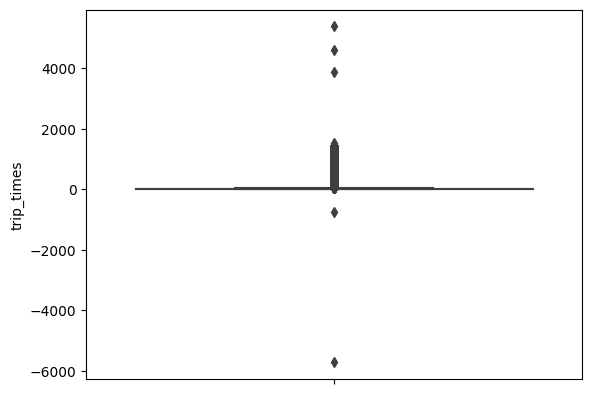

In [26]:
# 분단위
sns.boxplot(y="trip_times", data=frame_with_durations)
plt.show()

In [27]:
# 10%마다 해당되는 시간
for i in range(0, 100, 10):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value id ", var[-1])
# 양 끝쪽에 튀는 데이터 존재

0 percentile value is -5711.583333333333
10 percentile value is 3.8833333333333333
20 percentile value is 5.483333333333333
30 percentile value is 7.0
40 percentile value is 8.6
50 percentile value is 10.366666666666667
60 percentile value is 12.466666666666667
70 percentile value is 15.133333333333333
80 percentile value is 18.933333333333334
90 percentile value is 25.683333333333334
100 percentile value id  5382.066666666667


In [28]:
# 90%~100%마다 해당되는 시간
for i in range(90, 100):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value id ", var[-1])

90 percentile value is 25.683333333333334
91 percentile value is 26.75
92 percentile value is 27.95
93 percentile value is 29.366666666666667
94 percentile value is 31.016666666666666
95 percentile value is 33.03333333333333
96 percentile value is 35.6
97 percentile value is 39.083333333333336
98 percentile value is 44.416666666666664
99 percentile value is 54.46666666666667
100 percentile value id  5382.066666666667


In [29]:
# 0%~10%마다 해당되는 시간
for i in range(0, 11):
    var = frame_with_durations["trip_times"].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))

0 percentile value is -5711.583333333333
1 percentile value is 1.1833333333333333
2 percentile value is 1.8666666666666667
3 percentile value is 2.283333333333333
4 percentile value is 2.5833333333333335
5 percentile value is 2.85
6 percentile value is 3.0833333333333335
7 percentile value is 3.3
8 percentile value is 3.5
9 percentile value is 3.7
10 percentile value is 3.8833333333333333


In [30]:
# 시간이 이상하게 튀는 값 삭제(12시간까지) -> 더 줄여도될듯?
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_times>1) & (frame_with_durations.trip_times<120)]
print(frame_with_durations_modified.shape)

(8668281, 9)


In [31]:
var = frame_with_durations_modified["trip_times"].values
var = np.sort(var, axis=None)
print(var[0], var[-1])

1.0166666666666666 119.98333333333333


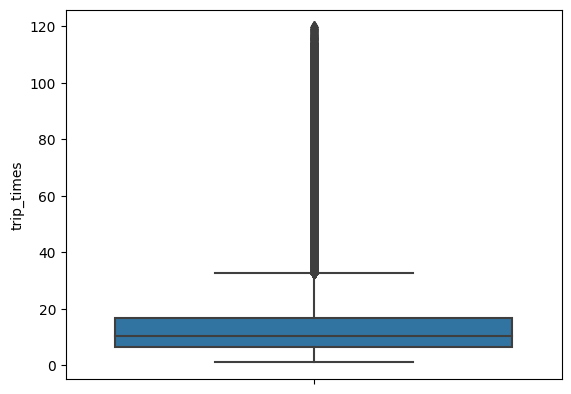

In [32]:
sns.boxplot(y="trip_times", data=frame_with_durations_modified)
plt.show()
# 왜 최댓값 30대???
# -> 1사분위수, 3사분위수에서 상자 길이의 1.5배 떨어진 거리가 최소, 최대값을 의미

c:\Users\sktmd\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


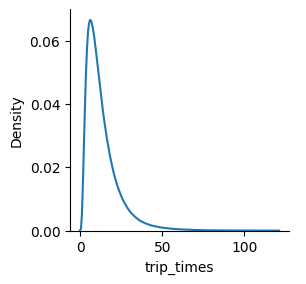

In [33]:
sns.FacetGrid(frame_with_durations_modified) \
    .map(sns.kdeplot, "trip_times") \
    .add_legend()
plt.show()

In [34]:
import math
frame_with_durations_modified['log_times'] = [math.log(i) for i in frame_with_durations_modified['trip_times'].values]


C:\Users\sktmd\AppData\Local\Temp\ipykernel_1048\2641135077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_with_durations_modified['log_times'] = [math.log(i) for i in frame_with_durations_modified['trip_times'].values]


c:\Users\sktmd\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


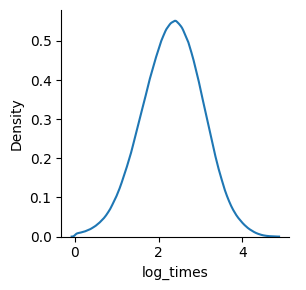

In [35]:
sns.FacetGrid(frame_with_durations_modified) \
    .map(sns.kdeplot, "log_times") \
    .add_legend()
plt.show()

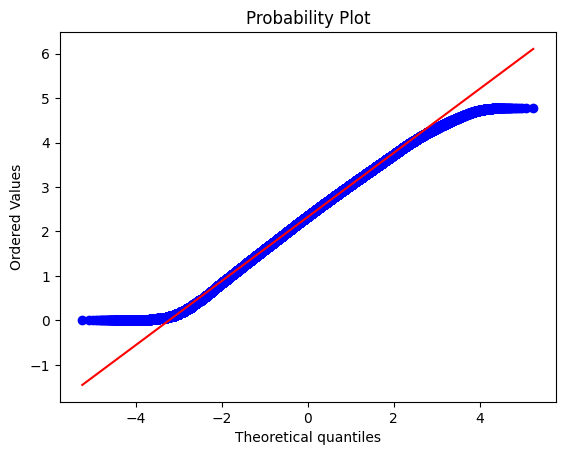

In [36]:
import scipy
scipy.stats.probplot(frame_with_durations_modified['log_times'].values, plot=plt)
plt.show()
# probplot ->  파란 점들이 빨간 선에 가까울수록 정규 분포를 띔

2. speed

C:\Users\sktmd\AppData\Local\Temp\ipykernel_1048\3401238407.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame_with_durations_modified['speed'] = 60 * (frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])


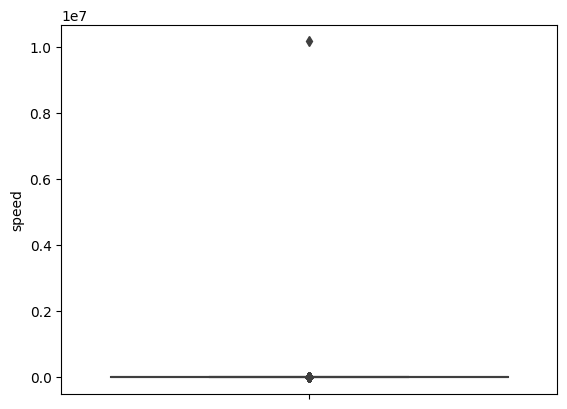

In [37]:
frame_with_durations_modified['speed'] = 60 * (frame_with_durations_modified['trip_distance']/frame_with_durations_modified['trip_times'])
sns.boxplot(y="speed", data=frame_with_durations_modified)
plt.show()

In [38]:
for i in range(0, 100, 10):
    var = frame_with_durations_modified['speed'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])

0 percentile value is 0.0
10 percentile value is 5.764705882352941
20 percentile value is 7.018050541516247
30 percentile value is 8.029739776951672
40 percentile value is 9.0
50 percentile value is 10.003597122302157
60 percentile value is 11.162790697674419
70 percentile value is 12.616822429906541
80 percentile value is 14.746987951807231
90 percentile value is 18.973116691285085
100 percentile value is 10181221.253731342


In [39]:
for i in range(90, 100):
    var = frame_with_durations_modified['speed'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])
# 끝 쪽에 튀는 값 존재

90 percentile value is 18.973116691285085
91 percentile value is 19.69957081545064
92 percentile value is 20.526315789473685
93 percentile value is 21.484615384615385
94 percentile value is 22.599905526688712
95 percentile value is 23.905740181268886
96 percentile value is 25.493050959629382
97 percentile value is 27.491740787801778
98 percentile value is 30.23821339950372
99 percentile value is 34.41370869033047
100 percentile value is 10181221.253731342


In [40]:
for i in range(0, 11):
    var = frame_with_durations_modified['speed'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])
# 끝쪽에 튀는 값 존재

0 percentile value is 0.0
1 percentile value is 3.2323232323232327
2 percentile value is 3.858520900321543
3 percentile value is 4.259541984732825
4 percentile value is 4.568527918781726
5 percentile value is 4.826498422712934
6 percentile value is 5.051449953227316
7 percentile value is 5.254054054054055
8 percentile value is 5.4362416107382545
9 percentile value is 5.60698689956332
10 percentile value is 5.764705882352941
100 percentile value is 10181221.253731342


In [41]:
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified['speed'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is", var[-1])

99.0 percentile value is 34.41370869033047
99.1 percentile value is 34.985915492957744
99.2 percentile value is 35.614629794826044
99.3 percentile value is 36.3082191780822
99.4 percentile value is 37.05146036161335
99.5 percentile value is 37.916666666666664
99.6 percentile value is 38.925714285714285
99.7 percentile value is 40.15384615384615
99.8 percentile value is 41.72117039586919
99.9 percentile value is 44.22786547700755
100 percentile value is 10181221.253731342


In [42]:
frame_with_durations_modified = frame_with_durations_modified[(frame_with_durations_modified.speed>0) & (frame_with_durations_modified.speed < 50)]

In [43]:
# 평균 속도
sum(frame_with_durations_modified['speed']) / float(len(frame_with_durations_modified['speed']))

11.481654321751463

3. trip distance

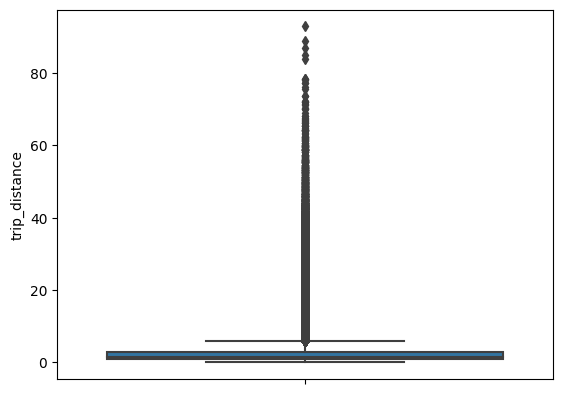

In [44]:
sns.boxplot(y="trip_distance", data=frame_with_durations_modified)
plt.show()

In [45]:
for i in range(0, 100, 10):
    var = frame_with_durations_modified['trip_distance'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])

0 percentile value is 0.01
10 percentile value is 0.6
20 percentile value is 0.83
30 percentile value is 1.04
40 percentile value is 1.3
50 percentile value is 1.57
60 percentile value is 1.91
70 percentile value is 2.48
80 percentile value is 3.44
90 percentile value is 6.31
100 percentile value is 92.93


In [46]:
for i in range(90, 100):
    var = frame_with_durations_modified['trip_distance'].values
    var = np.sort(var, axis=None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is", var[-1])

90 percentile value is 6.31
91 percentile value is 6.96
92 percentile value is 7.73
93 percentile value is 8.6
94 percentile value is 9.43
95 percentile value is 10.32
96 percentile value is 11.46
97 percentile value is 13.63
98 percentile value is 17.04
99 percentile value is 18.7
100 percentile value is 92.93


In [47]:
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_durations_modified["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.7
99.1 percentile value is 18.94
99.2 percentile value is 19.2
99.3 percentile value is 19.5
99.4 percentile value is 19.9
99.5 percentile value is 20.3
99.6 percentile value is 20.8
99.7 percentile value is 21.35
99.8 percentile value is 22.23
99.9 percentile value is 25.16
100 percentile value is  92.93


In [48]:
frame_with_durations_modified = frame_with_durations_modified[(frame_with_durations_modified.trip_distance>0) & (frame_with_durations_modified.trip_distance<30)]

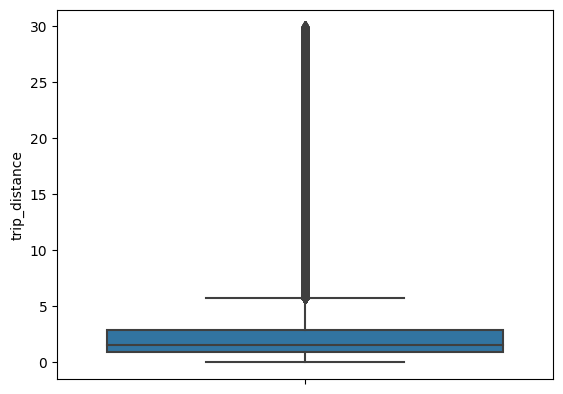

In [49]:
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)
plt.show()

4. total fare

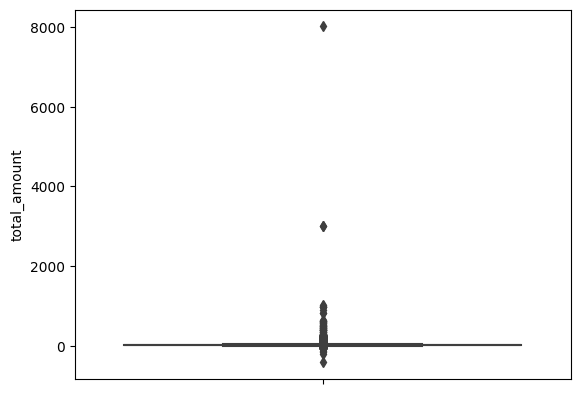

In [50]:
sns.boxplot(y="total_amount", data =frame_with_durations_modified)
plt.show()

In [51]:
for i in range(0,100,10):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -420.8
10 percentile value is 6.62
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.96
50 percentile value is 11.3
60 percentile value is 12.95
70 percentile value is 15.3
80 percentile value is 18.8
90 percentile value is 27.8
100 percentile value is  8016.8


In [52]:
for i in range(90,100):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 27.8
91 percentile value is 29.75
92 percentile value is 32.2
93 percentile value is 35.56
94 percentile value is 39.12
95 percentile value is 43.06
96 percentile value is 47.47
97 percentile value is 53.47
98 percentile value is 61.32
99 percentile value is 70.26
100 percentile value is  8016.8


In [53]:
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 70.26
99.1 percentile value is 70.27
99.2 percentile value is 70.27
99.3 percentile value is 70.27
99.4 percentile value is 73.06
99.5 percentile value is 73.2
99.6 percentile value is 75.67
99.7 percentile value is 77.76
99.8 percentile value is 84.8
99.9 percentile value is 98.88
100 percentile value is  8016.8


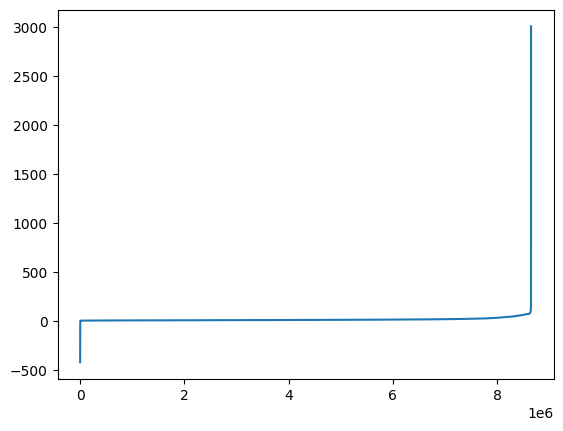

In [54]:
plt.plot(var[:-2])
plt.show()
# 끝값에서 튄다 -> 아직 이상한 값 존재

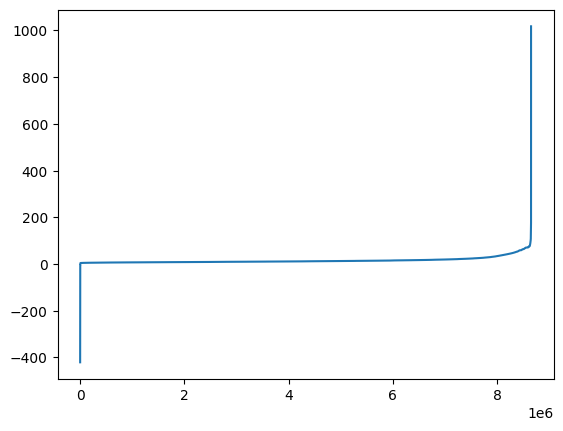

In [55]:
plt.plot(var[:-3])
plt.show()
# 끝값에서 튄다 -> 아직 이상한 값 존재

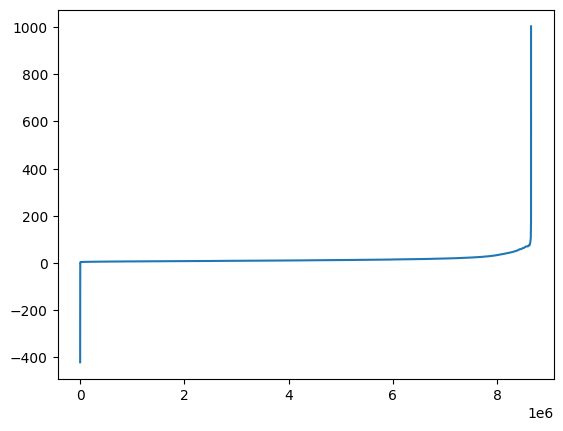

In [56]:
plt.plot(var[:-4])
plt.show()
# 끝값에서 튄다 -> 아직 이상한 값 존재

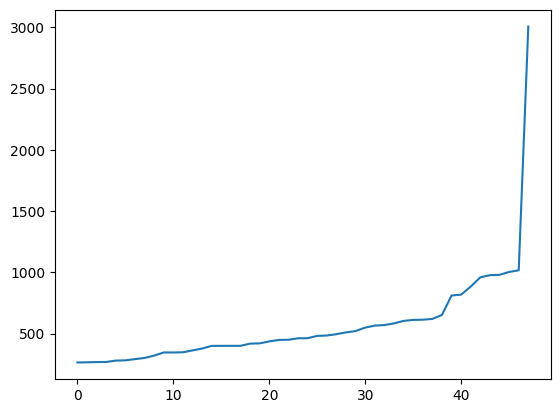

In [57]:
plt.plot(var[-50:-2])
plt.show()
# 1000언저리에서 끊어야함

5. tip_amount

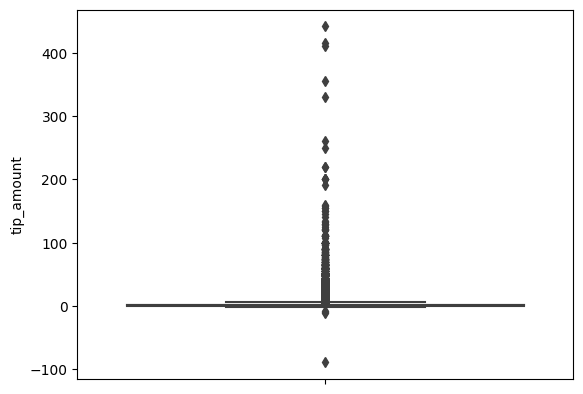

In [58]:
sns.boxplot(y="tip_amount", data =frame_with_durations_modified)
plt.show()

In [59]:
for i in range(0,100,10):
    var = frame_with_durations_modified["tip_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -88.8
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 0.0
40 percentile value is 1.0
50 percentile value is 1.4
60 percentile value is 1.76
70 percentile value is 2.06
80 percentile value is 2.7
90 percentile value is 3.99
100 percentile value is  441.71


In [60]:
for i in range(90,100,1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 27.8
91 percentile value is 29.75
92 percentile value is 32.2
93 percentile value is 35.56
94 percentile value is 39.12
95 percentile value is 43.06
96 percentile value is 47.47
97 percentile value is 53.47
98 percentile value is 61.32
99 percentile value is 70.26
100 percentile value is  8016.8


In [61]:
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_durations_modified["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 70.26
99.1 percentile value is 70.27
99.2 percentile value is 70.27
99.3 percentile value is 70.27
99.4 percentile value is 73.06
99.5 percentile value is 73.2
99.6 percentile value is 75.67
99.7 percentile value is 77.76
99.8 percentile value is 84.8
99.9 percentile value is 98.88
100 percentile value is  8016.8


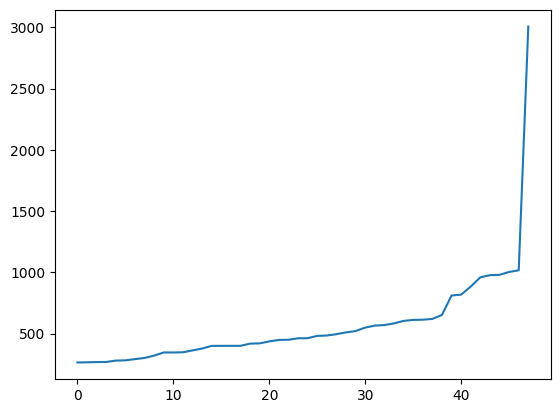

In [62]:
plt.plot(var[-50:-2])
plt.show()
# 1100언저리에서 끊어야함

In [63]:
# 1. 이상한 시간
# 2. 이상한 속도
# 3. 이상한 거리
# 4. 이상한 비용
# 5. 이상한 팁
def remove_outliers(new_frame):
    a = new_frame.shape[0]
    print("총 데이터 수 = ", a)

    # 시간
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 120)]
    c = temp_frame.shape[0]
    print ("시간 튀는 값의 개수:",(a-c))
    
    # 거리
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 30)]
    d = temp_frame.shape[0]
    print ("거리 튀는 값의 개수:",(a-d))

    # 속도
    temp_frame = new_frame[(new_frame.speed <= 50) & (new_frame.speed >= 0)]
    e = temp_frame.shape[0]
    print ("속도 튀는 값의 개수",(a-e))

    # 비용
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("비용 튀는 값의 개수:",(a-f))

    # 팁
    temp_frame = new_frame[(new_frame.tip_amount <1100) & (new_frame.tip_amount >0)]
    f = temp_frame.shape[0]
    print ("팁 튀는 값의 개수:",(a-f))

    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 120)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 30)]
    new_frame = new_frame[(new_frame.speed < 50) & (new_frame.speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    new_frame = new_frame[(new_frame.tip_amount <1100) & (new_frame.tip_amount >0)]

    print("전체 삭제 된 데이터 수", a-new_frame.shape[0])
    print("---")
    return new_frame

In [64]:
print("2018-01 데이터 제거 현황")
print("---")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("튀는 값 제거하고 남은 비율", float(len(frame_with_durations_outliers_removed))/len(frame_with_durations))

2018-01 데이터 제거 현황
---
총 데이터 수 =  8760687
시간 튀는 값의 개수: 25045
거리 튀는 값의 개수: 58699
속도 튀는 값의 개수 16996
비용 튀는 값의 개수: 5336
팁 튀는 값의 개수: 2895981
전체 삭제 된 데이터 수 2927664
---
튀는 값 제거하고 남은 비율 0.66581798893169



-----------------------------------------------------------------
1. 시간 구간 구해서 그룹핑(클러스터링은 이미 되어 있으므로 생략)

In [65]:
# Refer:https://www.unixtimestamp.com/
# 1514732400 : 2018-01-01 00:00:00 
# 1517410800 : 2018-02-01 00:00:00 
# 1519830000 : 2018-03-01 00:00:00
# 1522508400 : 2018-04-01 00:00:00 
# 1525100400 : 2018-05-01 00:00:00 
# 1527778800 : 2018-06-01 00:00:00

# 1546268400 : 2019-01-01 00:00:00 
# 1548946800 : 2019-02-01 00:00:00 
# 1551366000 : 2019-03-01 00:00:00
# 1554044400 : 2019-04-01 00:00:00 
# 1556636400 : 2019-05-01 00:00:00 
# 1559314800 : 2019-06-01 00:00:00

def add_pickup_bins(frame, month, year):
    # 탑승 시간에 대한 배열
    unix_pickup_times = [i for i in frame['pickup_times'].values]
    unix_times = [[1514732400, 1517410800, 151983000, 1522508400, 1525100400, 1527778800], \
        [1546268400, 1548946800, 1551366000, 1554044400, 1556636400, 1559314800]]

    # 해당하는 년도와 월에 대한 시간
    start_pickup_unix = unix_times[year-2018][month-1]
    # (int((i-start_pickup_unix)/600)+33) : est 표준 시간 -> gmt 표준 시간(미국 동부)
    # 해당 년도 월에 대해서 10분 간격으로 나누기
    tenminutewise_binned_unix_pickup_times = [(int((((i - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [66]:
jan_2018_frame = add_pickup_bins(frame_with_durations_outliers_removed, 1, 2018)

C:\Users\sktmd\AppData\Local\Temp\ipykernel_1048\2461794554.py:26: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  tenminutewise_binned_unix_pickup_times = [(int((((i - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))-start_pickup_unix)/600)+33) for i in unix_pickup_times]


In [67]:
# 2018년도 1월 시간과 지역별 그룹화
jan_2018_groupby = jan_2018_frame[['PULocationID', 'pickup_bins', 'trip_distance']].groupby(['PULocationID', 'pickup_bins']).count()

In [68]:
jan_2018_frame.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,total_amount,tip_amount,trip_times,pickup_times,speed,pickup_bins
2,2,0.8,262,141,8.30,1.00,5.916667,2018-01-01 00:08:26,8.112676,87
4,2,2.5,246,239,16.55,2.75,17.800000,2018-01-01 00:09:18,8.426966,87
6,2,1.7,50,239,12.35,2.05,10.266667,2018-01-01 00:38:08,9.935065,90
7,1,0.7,239,238,6.30,1.00,2.400000,2018-01-01 00:49:29,17.500000,91
8,1,1.0,238,24,8.50,1.70,4.450000,2018-01-01 00:56:38,13.483146,92


In [69]:
jan_2018_groupby.head()

trip_distance
PULocationID pickup_bins               
1            107                      1
             124                      1
             267                      1
             704                      1
             720                      1

In [70]:
# 앞까지 했던 방식을 2019-1, 2019-2, 2019-3에 대해 똑같이 적용
def datapreparation(month, month_no, year_no):

    print("return_with_trip_times..")
    frame_with_durations = return_with_trip_times(month)

    print("Remove outliers..")
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)

    print('Final groupying')
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed, month_no, year_no)
    final_groupby_frame = final_updated_frame[['PULocationID', 'pickup_bins', 'trip_distance']].groupby(['PULocationID', 'pickup_bins']).count()

    return final_updated_frame, final_groupby_frame


month_jan_2019 = pd.read_parquet('yellow_tripdata_2019-01.parquet',engine='pyarrow')
month_feb_2019 = pd.read_parquet('yellow_tripdata_2019-02.parquet',engine='pyarrow')
month_mar_2019 = pd.read_parquet('yellow_tripdata_2019-03.parquet',engine='pyarrow')

jan_2019_frame, jan_2019_groupby = datapreparation(month_jan_2019, 1, 2019)
feb_2019_frame, feb_2019_groupby = datapreparation(month_feb_2019, 2, 2019)
mar_2019_frame, mar_2019_groupby = datapreparation(month_mar_2019, 3, 2019)

return_with_trip_times..


C:\Users\sktmd\AppData\Local\Temp\ipykernel_1048\3260386666.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['trip_times'] = durations
C:\Users\sktmd\AppData\Local\Temp\ipykernel_1048\3260386666.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['pickup_times'] = duration_pickup
C:\Users\sktmd\AppData\Local\Temp\ipykernel_1048\3260386666.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Remove outliers..
총 데이터 수 =  7696617
시간 튀는 값의 개수: 27889
거리 튀는 값의 개수: 58240
속도 튀는 값의 개수 15120
비용 튀는 값의 개수: 8793
팁 튀는 값의 개수: 2438772
전체 삭제 된 데이터 수 2474908
---
Final groupying


C:\Users\sktmd\AppData\Local\Temp\ipykernel_1048\2461794554.py:26: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  tenminutewise_binned_unix_pickup_times = [(int((((i - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))-start_pickup_unix)/600)+33) for i in unix_pickup_times]


return_with_trip_times..


C:\Users\sktmd\AppData\Local\Temp\ipykernel_1048\3260386666.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['trip_times'] = durations
C:\Users\sktmd\AppData\Local\Temp\ipykernel_1048\3260386666.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['pickup_times'] = duration_pickup
C:\Users\sktmd\AppData\Local\Temp\ipykernel_1048\3260386666.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Remove outliers..
총 데이터 수 =  7049370
시간 튀는 값의 개수: 25487
거리 튀는 값의 개수: 52741
속도 튀는 값의 개수 13949
비용 튀는 값의 개수: 11258
팁 튀는 값의 개수: 2106999
전체 삭제 된 데이터 수 2138499
---
Final groupying


C:\Users\sktmd\AppData\Local\Temp\ipykernel_1048\2461794554.py:26: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  tenminutewise_binned_unix_pickup_times = [(int((((i - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))-start_pickup_unix)/600)+33) for i in unix_pickup_times]


return_with_trip_times..


C:\Users\sktmd\AppData\Local\Temp\ipykernel_1048\3260386666.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['trip_times'] = durations
C:\Users\sktmd\AppData\Local\Temp\ipykernel_1048\3260386666.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_frame['pickup_times'] = duration_pickup
C:\Users\sktmd\AppData\Local\Temp\ipykernel_1048\3260386666.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Remove outliers..
총 데이터 수 =  7866620
시간 튀는 값의 개수: 27494
거리 튀는 값의 개수: 57473
속도 튀는 값의 개수 15025
비용 튀는 값의 개수: 13582
팁 튀는 값의 개수: 2408533
전체 삭제 된 데이터 수 2444621
---
Final groupying


C:\Users\sktmd\AppData\Local\Temp\ipykernel_1048\2461794554.py:26: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  tenminutewise_binned_unix_pickup_times = [(int((((i - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))-start_pickup_unix)/600)+33) for i in unix_pickup_times]


2. smoothing(평활화)
-> 데이터가 없는 구간 확인
-> 0으로 채워주고, 평균값으로 설정

In [71]:
print(jan_2018_groupby)

                          trip_distance
PULocationID pickup_bins               
1            107                      1
             124                      1
             267                      1
             704                      1
             720                      1
...                                 ...
265          4507                     1
             4526                     1
             4531                     2
             4539                     1
             4548                     1

[304738 rows x 1 columns]


In [72]:
# 각 지역마다 데이터가 존재하는  시간대 리스트 구하기

def return_unq_pickup_bins(frame):
    values = []
    for i in range(1, 266): # 265개의 PULocationID
        new = frame[frame['PULocationID'] == i] # 지역별
        list_unq = list(set(new['pickup_bins'])) # pickup이 존재하는 시간 리스트
        list_unq.sort()
        values.append(list_unq) # 시간대마다 values에 누적
    return values

In [73]:
#jan
jan_2018_unique = return_unq_pickup_bins(jan_2018_frame)
jan_2019_unique = return_unq_pickup_bins(jan_2019_frame)

#feb
feb_2019_unique = return_unq_pickup_bins(feb_2019_frame)

#march
mar_2019_unique = return_unq_pickup_bins(mar_2019_frame)

In [74]:
# 31일 * 24시간 * 60분 / 10분 = 4464
for i in range(1, 266):
    print(i, "번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수", 4464-len(set(jan_2018_unique[i-1])))
    print("-"* 60)

1 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4419
------------------------------------------------------------
2 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4461
------------------------------------------------------------
3 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4454
------------------------------------------------------------
4 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 928
------------------------------------------------------------
5 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4464
------------------------------------------------------------
6 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4450
------------------------------------------------------------
7 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 1774
------------------------------------------------------------
8 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4429
------------------------------------------------------------
9 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 4451
------------------------------------------------------------
10 번째 구역에서 10분 간격안에 픽업 데이터가 없는 경우의 개수 3493
-------------------------------

지역간 편차 큰거 같음

In [75]:
# 탑승 기록이 없으면 0으로 채우기
# count_values: 각 지역 각 10분 간격에 픽업 수
# values: 픽업 기록이 있는 간격의 set
def fill_missing(count_values, values):
    smoothed_regions = []
    ind = 0
    for r in range(1, 266): # 각 구역마다
        smoothed_bins = []
        for i in range(4464):
            if i in values[r-1]: # interval 안에 탑승 기록이 있으면
                smoothed_bins.append(count_values[ind])
                ind += 1
            else: # interval 안에 탑승 기록이 없으면
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [76]:
# 빈값을 평균으로 채우기
# interval 안에 pickup 기록이 없다면
# pickup 기록이 있는 자신과 가장 가까운 양 끝값을 이용하여 평균을 구함
def smoothing(count_values,values):
    smoothed_regions=[] # 각 지역마다 최종 smoothed 값을 저장할 리스트
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(1,266): # 지역마다
        smoothed_bins=[] # 최종 smoothed 값을 저장할 리스트
        repeat=0
        for i in range(4464): # interval 마다
            if repeat!=0: # 같은 interval을 여러 번 계산 방지
                repeat-=1
                continue
            if i in values[r-1]: # interval 안에 픽업 기록이 존재하면
                smoothed_bins.append(count_values[ind]) # interval을 리스트에 추가
            else:
                if i!=0: # 첫 구간이 아니면 (left~rigth or right~끝)
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r-1]: # interval안에 픽업이 없는 경우 평균값으로 채워져야 하므로 넘어감
                            continue
                        else:
                            right_hand_limit=j # interval안에 픽업이 존재하는 경우에 right_limit이 됨
                            break
                    if right_hand_limit==0:
                    #Case 1: right~끝
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464): # right~끝까지 평균으로 채우기              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: left~right
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1): # left~right까지 평균으로 채우기   
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: 처음~right
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r-1]:
                            continue
                        else:
                            right_hand_limit=j # interval 안에 픽업이 존재하는 경우 right가 됨
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):# 처음~left까지 평균으로 채우기
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [77]:
jan_2018_fill = fill_missing(jan_2018_groupby['trip_distance'].values , jan_2018_unique)

In [78]:
jan_2018_smooth = smoothing(jan_2018_groupby['trip_distance'].values, jan_2018_unique)

In [79]:
# 2018 1월 = 4464
# 2019 1월 = 4464
# 2019 2월 = 4032
# 2019 3월 = 4320
# 4464 * 255 = 1,182,960
print("모든 클러스터 사이에 10분 interval 수", len(jan_2018_fill))

모든 클러스터 사이에 10분 interval 수 1182960


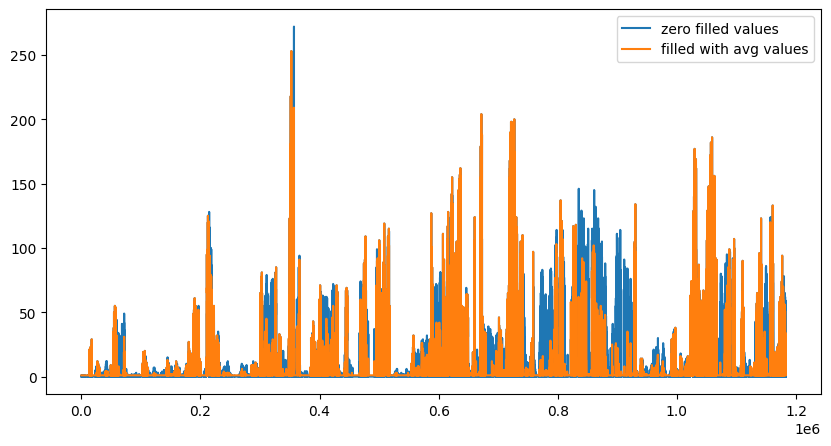

In [87]:
# 2018-01 10분 interval 탑승 빈도
plt.figure(figsize=(10, 5))
plt.plot(jan_2018_fill[0:1182960], label = "zero filled values")
plt.plot(jan_2018_smooth[0:1182960], label="filled with avg values")
plt.legend()
plt.show()

In [104]:
jan_2018_smooth = smoothing(jan_2018_groupby['trip_distance'].values, jan_2018_unique)
jan_2019_smooth = fill_missing(jan_2019_groupby['trip_distance'].values, jan_2019_unique)
feb_2019_smooth = fill_missing(feb_2019_groupby['trip_distance'].values, feb_2019_unique)
mar_2019_smooth = fill_missing(mar_2019_groupby['trip_distance'].values, mar_2019_unique)

# 2019 3개의 달을 합산한 리스트
regions_cum = []

# 2019 1월 = 4464
# 2019 2월 = 4032
# 2019 3월 = 4320

for i in range(1, 266):
    regions_cum.append(jan_2019_smooth[4464*i:4464*(i+1)]+jan_2019_smooth[4032*i:4032*(i+1)]+mar_2019_smooth[4320*i:4320*(i+1)])


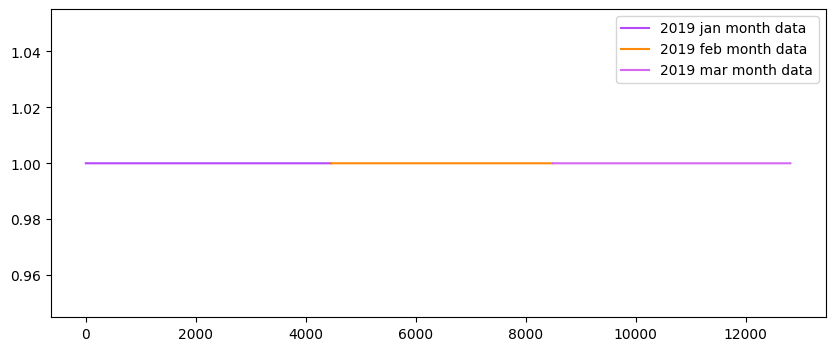

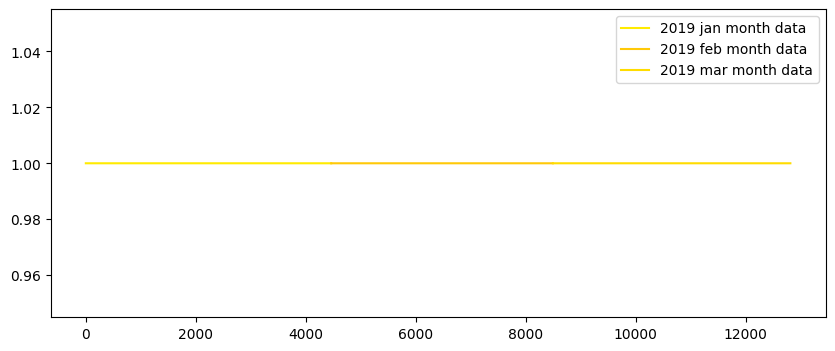

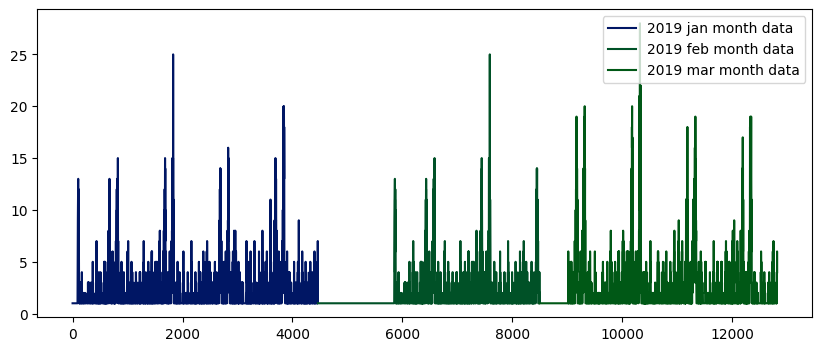

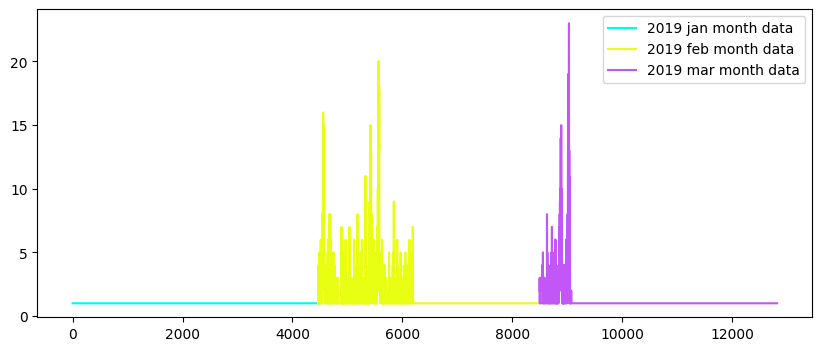

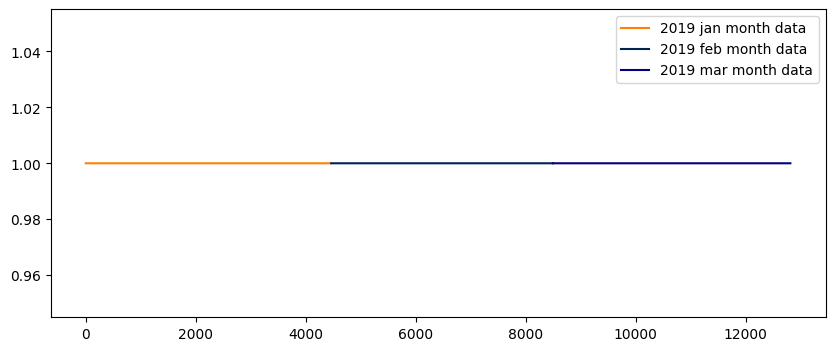

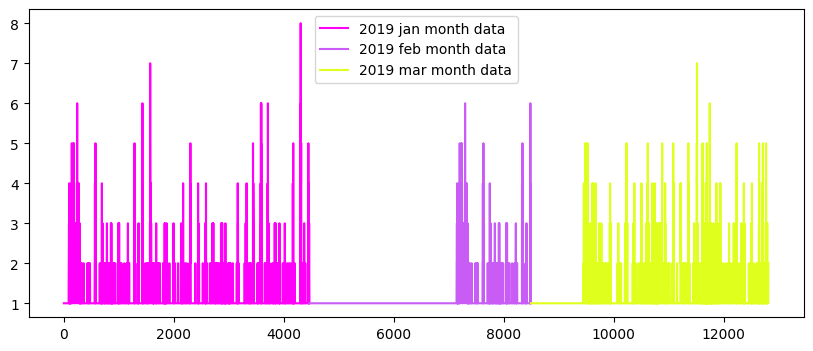

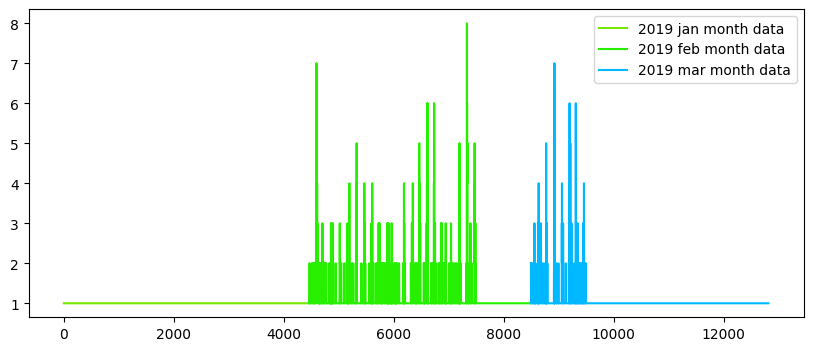

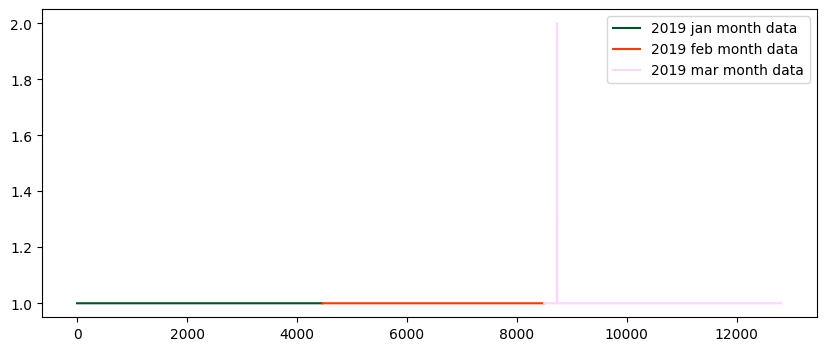

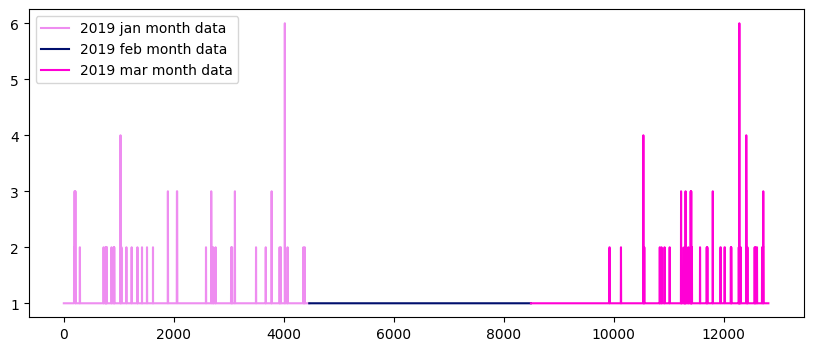

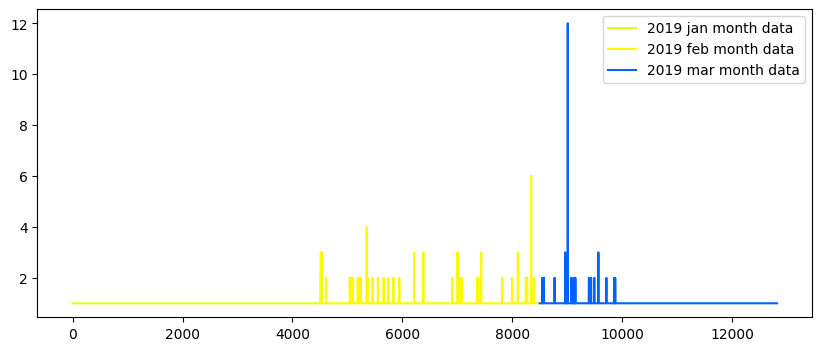

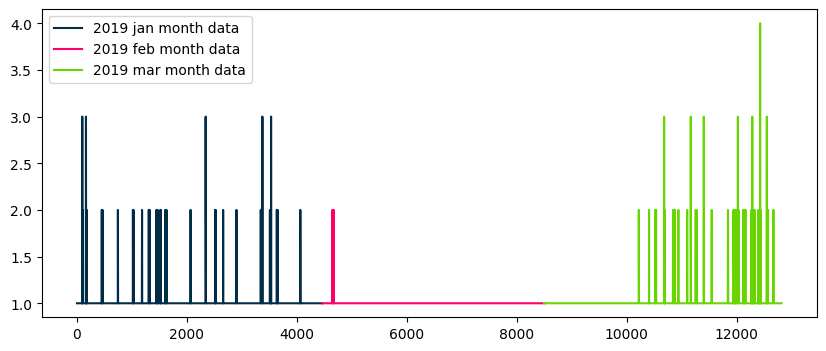

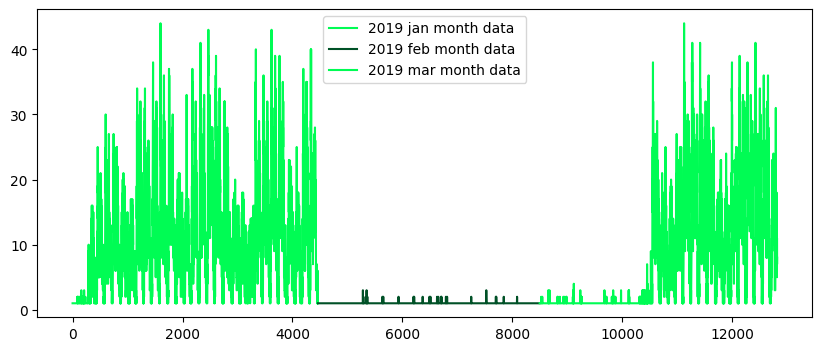

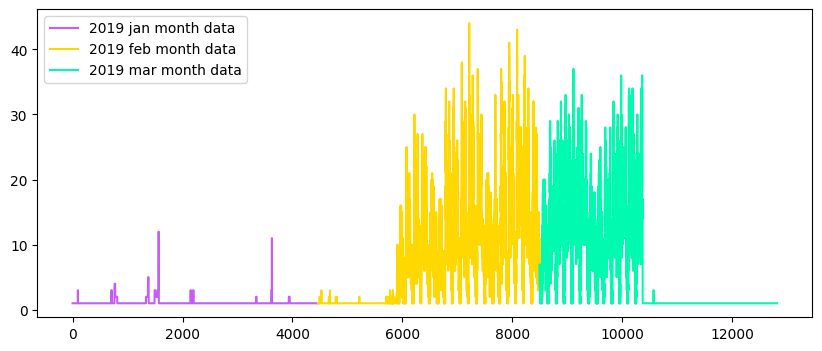

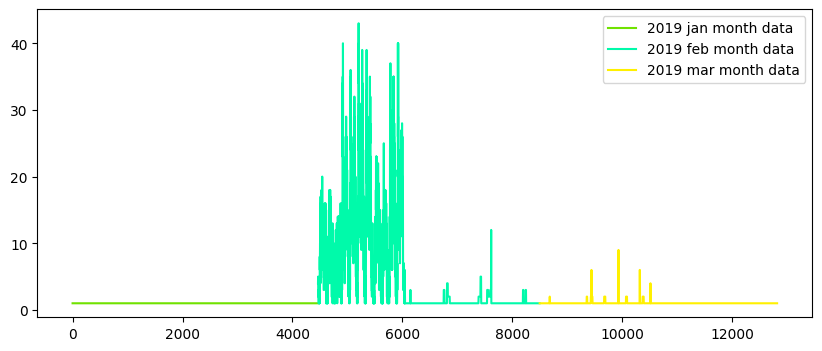

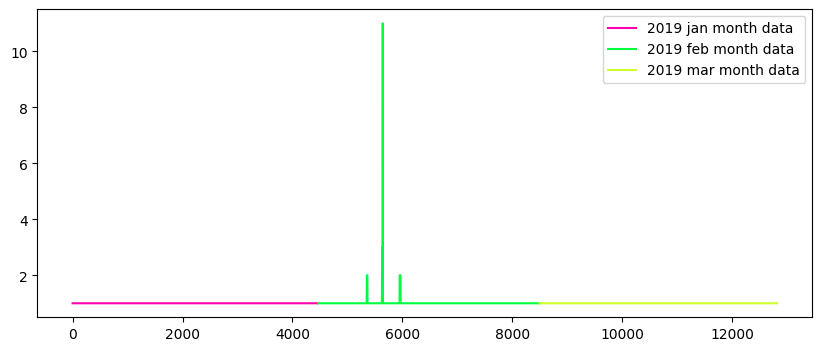

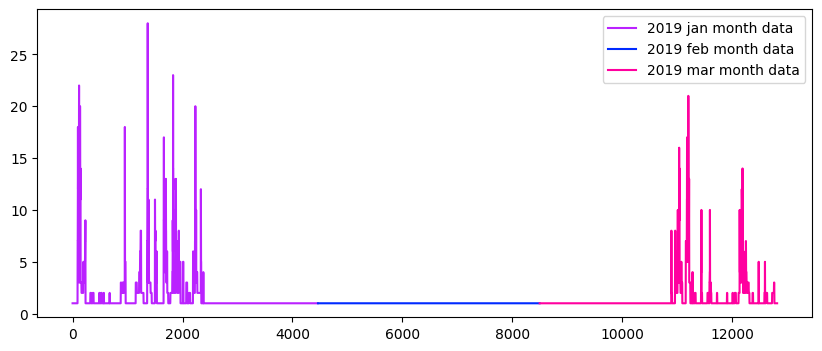

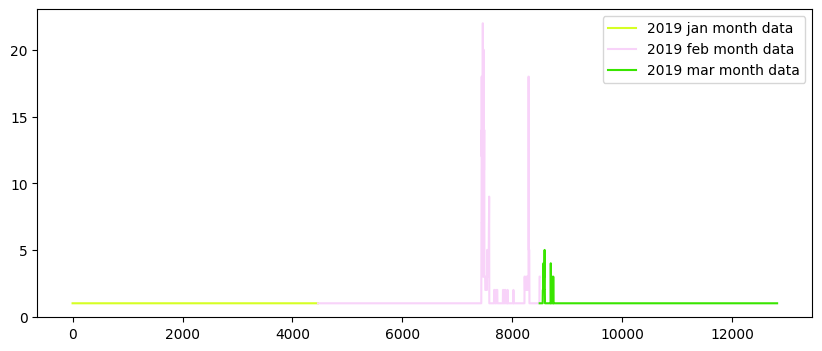

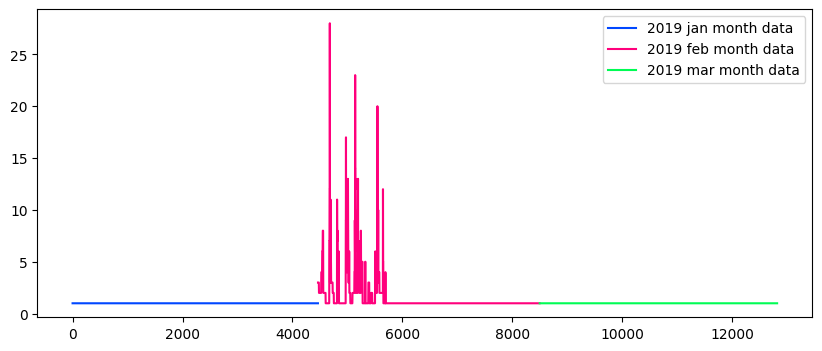

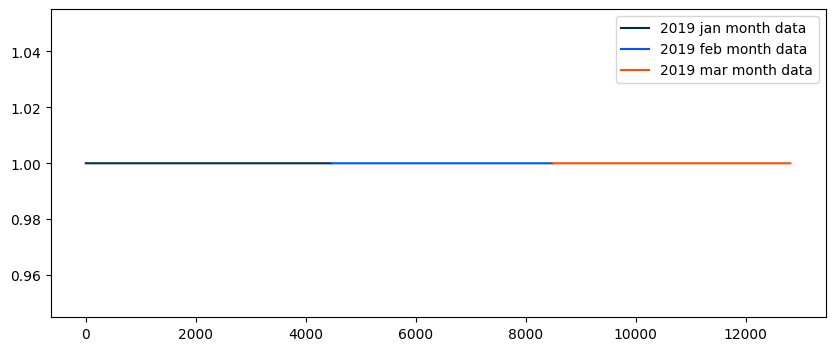

In [92]:
def uniqueish_color():
    # 랜덤 색상 주기
    return plt.cm.gist_ncar(np.random.random())

first_x = list(range(0, 4464))
second_x = list(range(4464, 8496))
third_x = list(range(8496, 12816))

for i in range(1, 20): # 지역별 월별 탑승 추이(반복문 숫자 바꿔서 지역 변경)
    plt.figure(figsize=(10, 4))
    plt.plot(first_x, regions_cum[i-1][:4464], color=uniqueish_color(), label='2019 jan month data')
    plt.plot(second_x, regions_cum[i-1][4464:8496], color=uniqueish_color(), label='2019 feb month data')
    plt.plot(third_x, regions_cum[i-1][8496:], color=uniqueish_color(), label='2019 mar month data')
    plt.legend()
    plt.show()

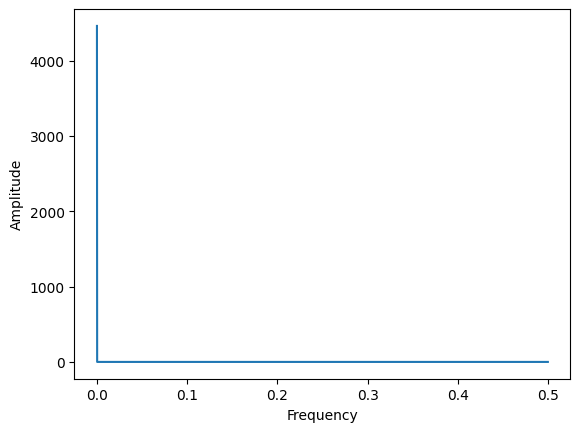

In [94]:
# 주파수 분석 -> 뭔지 모르겠음
Y = np.fft.fft(np.array(jan_2019_smooth)[0:4460])

freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot(freq[:int(n/2)], np.abs(Y)[:int(n/2)])
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [109]:
# 2018 1월: 학습
# 2019 1월: 예측
ratios_jan = pd.DataFrame()
ratios_jan['Given'] = jan_2018_smooth
ratios_jan['Prediction'] = jan_2019_smooth
ratios_jan['Ratios'] = ratios_jan['Prediction']*1.0/ratios_jan['Given']*1.0

In [110]:
print(ratios_jan.shape)

(1182960, 3)


# modeling

1. R_t = P_t(2016) / P_t(2015)
2. 2019년도 알려진 값을 이용하여 예측

simple moving average

In [113]:
# 비율(ratios)를 이용
def MA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*265):
        if i%4464==0:# 시작시
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio) # 예상비율(simple moving average)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio)) # 예상 비율을 통한 다음 예상 값
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1)))) #예상값-실제값
        if i+1>=window_size: # 이전 시간 3개의 값을 통한 평균
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else: # 1,2,3의 경우는 데이터 부족이므로 0에서부터 평균
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    # mape 에러와 mse 에러
    # https://biology-statistics-programming.tistory.com/59
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [114]:
# 테스트값(predicted value)를 이용
def MA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*265):
        predicted_values.append(predicted_value) # 예상값(simple  moving average)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:  # 이전 시간 window-size 만큼의 값을 통한 평균
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else: # 1,2,3의 경우는 데이터 부족이므로 0에서부터 평균
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

weighted moving averages

In [115]:
# ratio
def WA_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*265):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j] # Weighted moving average
                sum_of_coeff+=j # N(N+1) / 2
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [116]:
# predicted value
def WA_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*265):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j] # Weighted moving average
                sum_of_coeff+=j # N(N+1)/ 2
            predicted_value=int(sum_values/sum_of_coeff)
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

Exponential Weighted Moving Averages

In [117]:
# ratio
def EA_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*265):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i]) # Exponential Weighted Moving Averages
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [119]:
# predicted value
def EA_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*265):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i])) # Exponential Weighted Moving Averages
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [120]:
mean_err=[0]*10
median_err=[0]*10
ratios_jan,mean_err[0],median_err[0]=MA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[1],median_err[1]=MA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[2],median_err[2]=WA_R_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[3],median_err[3]=WA_P_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[4],median_err[4]=EA_R1_Predictions(ratios_jan,'jan')
ratios_jan,mean_err[5],median_err[5]=EA_P1_Predictions(ratios_jan,'jan')

In [121]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2019 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2019 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2019 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.6105694457240936       MSE:  147.61523889227024
Moving Averages (2019 Values) -                        MAPE:  0.434534142992721        MSE:  48.79367856901332
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.6120060797140326       MSE:  143.3001115844999
Weighted Moving Averages (2019 Values) -               MAPE:  0.40815826587099446       MSE:  38.673046425914656
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.6181576942034285       MSE:  140.3796104686549
Exponential Moving Averages (2019 Values) -         MAPE:  0.40434105883441

Regression Model

In [122]:
print(len(regions_cum))

265


In [123]:
print(len(regions_cum[0]))

12816


In [128]:
print(np.array(regions_cum).shape)

(265,)


C:\Users\sktmd\AppData\Local\Temp\ipykernel_1048\3214334102.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.array(regions_cum).shape)


In [152]:
# split train and test
# 2018 1월 = 4464
# 2019 1월 = 4464
# 2019 2월 = 4032
# 2019 3월 = 4320


# 마지막 5개의 interval 
number_of_time_stamps = 5

# output varaible
# it is list of lists
# it will contain number of pickups 12811 for each cluster
output = []


# 위도 경도 대신 목적지
tsne_destination = []

# we will code each day 
# sunday = 0, monday=1, tue = 2, wed=3, thur=4, fri=5,sat=6
# for every cluster we will be adding 12811 values, each value represent to which day of the week that pickup bin belongs to
# it is list of lists
tsne_weekday = []

# its an numbpy array, of shape (523960, 5)
# each row corresponds to an entry in out data
# for the first row we will have [f0,f1,f2,f3,f4] fi=number of pickups happened in i+1th 10min intravel(bin)
# the second row will have [f1,f2,f3,f4,f5]
# the third row will have [f2,f3,f4,f5,f6]
# and so on...
tsne_feature = []


tsne_feature = [0]*number_of_time_stamps
for i in range(1, 266):
    # 위치별
    tsne_destination.append([i for i in range(1, 266)]*12811)
    # 날짜별 
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4032+4320)])
    # 이전 값을 통해
    tsne_feature = np.vstack((tsne_feature, [regions_cum[i-1][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i-1])-number_of_time_stamps)]))
    output.append(regions_cum[i-1][5:])
tsne_feature = tsne_feature[1:]

In [153]:
# 끝값 처리 필요ㅠ
np.array(regions_cum[264]).shape

(8352,)

In [155]:
# exponential moving averages 사용

# upto now we computed 8 features for every data point that starts from 50th min of the day
# 1. cluster center lattitude
# 2. cluster center longitude
# 3. day of the week 
# 4. f_t_1: number of pickups that are happened previous t-1th 10min intravel
# 5. f_t_2: number of pickups that are happened previous t-2th 10min intravel
# 6. f_t_3: number of pickups that are happened previous t-3th 10min intravel
# 7. f_t_4: number of pickups that are happened previous t-4th 10min intravel
# 8. f_t_5: number of pickups that are happened previous t-5th 10min intravel

# from the baseline models we said the exponential weighted moving avarage gives us the best error
# we will try to add the same exponential weighted moving avarage at t as a feature to our data
# exponential weighted moving avarage => p'(t) = alpha*p'(t-1) + (1-alpha)*P(t-1) 
alpha=0.3

# it is a temporary array that store exponential weighted moving avarage for each 10min intravel, 
# for each cluster it will get reset
# for every cluster it contains 13104 values
predicted_values=[]

# it is similar like tsne_lat
# it is list of lists
# predict_list is a list of lists [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lsits]
predict_list = []
tsne_flat_exp_avg = []
for r in range(1,265):
    for i in range(0,12816):
        if i==0: # 초기값
            predicted_value= regions_cum[r-1][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        # alpha * 이전값 + (1-alpha) * 현재값
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r-1][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [157]:
print("size of train data :", int(12811*0.7))
print("size of test data :", int(12811*0.3))

size of train data : 8967
size of test data : 3843


In [163]:
# 7:3 비율로 훈련, 테스트 케이스 분리
train_features =  [tsne_feature[(i-1)*12811:(12811*(i-1)+8967)] for i in range(1,266)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[(12811*(i-1))+8967:12811*(i)] for i in range(1,266)]

In [164]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

# 8967개의 훈련 케이스
# 3844개의 테스트 케이스

Number of data clusters 265 Number of data points in trian data 8967 Each data point contains 5 features
Number of data clusters 265 Number of data points in test data 3844 Each data point contains 5 features


In [165]:
# 훈련
tsne_train_flat_destination = [i[:8967] for i in tsne_destination]
tsne_train_flat_weekday = [i[:8967] for i in tsne_weekday]
tsne_train_flat_output = [i[:8967] for i in output]
tsne_train_flat_exp_avg = [i[:8967] for i in predict_list]

In [168]:
# 테스트
tsne_test_flat_destination = [i[8967:] for i in tsne_destination]
tsne_test_flat_weekday = [i[8967:] for i in tsne_weekday]
tsne_test_flat_output = [i[8967:] for i in output]
tsne_test_flat_exp_avg = [i[8967:] for i in predict_list]

MemoryError: 